In [1]:
import os
from time import time
import numpy as np
import sys
sys.path.append('../')

from utils.codification_cnn import FitnessCNN, FitnessCNNParallel
from utils.datamanager import DataManager
from utils.codification_ops import ChromosomeOp, OperationBlock, CNN, Inputs
from GA.geneticAlgorithm import TwoLevelGA


Using TensorFlow backend.


In [2]:
# Chromosome parameters
ChromosomeOp._max_initial_blocks = 5
ChromosomeOp._grow_prob = 0.15
ChromosomeOp._decrease_prob = 0.25
#ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 2
ChromosomeOp.N_BLOCKS = 2

OperationBlock._change_op_prob = 0.15
OperationBlock._change_concat_prob = 0.15

CNN.possible_activations = ['relu', 'elu', 'prelu']
CNN.filters_mul_range = [0.7, 1.2]
CNN.dropout_range = [0, 0.7]
CNN.possible_k = [1, 3, 5]
CNN.k_prob = 0.2
CNN.drop_prob = 0.2
CNN.filter_prob = 0.2
CNN.act_prob = 0.2

Inputs._mutate_prob = 0.5

    
data_folder = '../../datasets/MNIST_variations'
command = 'python3 ../train_gen.py'
verbose = 0
experiments_folder = '../../exp_op_coding2'

gpus = 2

'''
data_folder = '/home/daniel/datasets/MNIST_variations'
command = 'python ./../train_gen.py'
verbose = 1
experiments_folder = '../exps_testing'
gpus = 1
skip = 1
'''

"\ndata_folder = '/home/daniel/datasets/MNIST_variations'\ncommand = 'python ./../train_gen.py'\nverbose = 1\nexperiments_folder = '../exps_testing'\ngpus = 1\nskip = 1\n"

In [3]:
fitness_cnn = FitnessCNN()    

In [4]:
c = ChromosomeOp.random_individual()
print(c)


||Identity||woCAT||1||
||CNN|F:0.75|K:1|A:relu|D:0.40||woCAT||10||
||CNN|F:1.14|K:5|A:prelu|D:0.40||CAT||011||
||Maxpool||CAT||0101||



In [5]:
# dataset params:
data_folder = data_folder
classes = []

# genetic algorithm params:
generations = -1
population_first_level = 20
population_second_level = 8
training_hours = 24
save_progress = True
maximize_fitness = False
statistical_validation = False
frequency_second_level = 2
start_level2 = 1


# Fitness params
epochs = 15
batch_size = 128
verbose = verbose
redu_plat = False
early_stop = 0
warm_up_epochs = 0
base_lr = 0.05
smooth = 0.1
cosine_dec = False
lr_find = False
precise_eps = 75
include_time = False
test_eps=200

datasets = ['MB', 'MBI', 'MRB', 'MRD', 'MRDBI']
datasets = ['cifar10']

Loading file ../../exp_cifar10_time/cifar10/genetic/0_2019-12-13-16:28/GA_experiment
Best Gen -> 
||CNN|F:0.90|K:5|A:elu|D:0.50||woCAT||1||
||Identity||woCAT||10||
||CNN|F:0.90|K:3|A:relu|D:0.20||CAT||111||
||CNN|F:0.75|K:5|A:elu|D:0.10||woCAT||0001||
||CNN|F:0.74|K:1|A:prelu|D:0.10||CAT||10001||

With Fitness (val): 0.0599 and (test): 0.0511


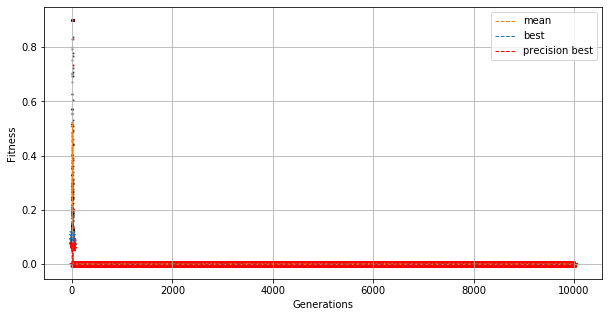

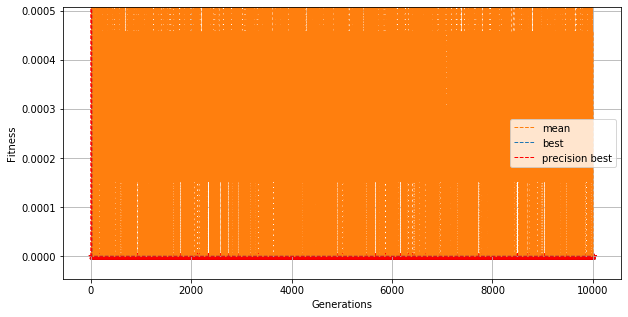

(||CNN|F:0.90|K:5|A:elu|D:0.50||woCAT||1||
 ||Identity||woCAT||10||
 ||CNN|F:0.90|K:3|A:relu|D:0.20||CAT||111||
 ||CNN|F:0.75|K:5|A:elu|D:0.10||woCAT||0001||
 ||CNN|F:0.74|K:1|A:prelu|D:0.10||CAT||10001||, 0.0511)

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
experiments_folder = '../../exp_cifar10_time'
dataset = datasets[0]
exp_folder = os.path.join(experiments_folder, dataset)
folder = os.path.join(exp_folder, 'genetic')


generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
generational.finishing_evolution(show=True)


In [ ]:
#experiments_folder = '../../exp_cifar10_time'
experiments_folder = '../../exp_cifar10_time_v2'

description = "Concatenation of all inputs wo projection. Wo Earlystopping, k:(1,3,5)"
experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)
    
    try:
        generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
    except:
        # Load data
        num_clases = 100 if dataset == 'cifar100' else 10
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, num_clases=num_clases) #, max_examples=8000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps, include_time=include_time, test_eps=test_eps)

        fitness_cnn.save(fitness_file)

        del dm, data

        fitness = FitnessCNNParallel()
        fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                       fp=32, main_line=command)
        generational = TwoLevelGA(chromosome=c,
                                  fitness=fitness,
                                  generations=generations,
                                  population_first_level=population_first_level,
                                  population_second_level=population_second_level,
                                  training_hours=training_hours,
                                  save_progress=save_progress,
                                  maximize_fitness=maximize_fitness,
                                  statistical_validation=statistical_validation,
                                  folder=folder,
                                  start_level2=start_level2,
                                  frequency_second_level=frequency_second_level)
        generational.print(description)

        
    ti_all = time()
    print(generational.generation)
    print(generational.num_generations)
    if generational.generation < generational.num_generations:
        winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))
    



EVOLVING IN DATASET cifar10 ...

Loading file ../../exp_cifar10_time_v2/cifar10/genetic/1_2020-01-04-18:45/GA_experiment
18
10000

Start evolution process...


18) Ranking level 1... Models to train: 0 ...OK (in 0.00 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.007

18) Ranking level 2... Models to train: 0 ...OK (in 0.00 minutes)
Saving... Elapsed saved time: 0.015

Generation (18) in 0.00 minutes.
Best first level fitness: 0.06990
Best second level fitness: 0.05890

19) Ranking level 1... Models to train: 15 ...OK (in 98.26 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.004

19) Ranking level 2... Models to train: 3 ...OK (in 138.56 minutes)
Saving... Elapsed saved time: 0.004

20) Ranking level 1... Models to train: 14 ...OK (in 100.04 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.004

20) Ranking level 2... Models to train: 0 ...OK (in 0.00 minutes)
Saving... Elapsed saved time: 0

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

winner = generational.best_individual['winner']
print(winner)


||CNN|F:1.08|K:3|A:elu|D:0.05||woCAT||1||
||CNN|F:1.04|K:3|A:relu|D:0.15||woCAT||01||
||CNN|F:1.00|K:3|A:prelu|D:0.20||SUM||101||
||CNN|F:0.96|K:3|A:relu|D:0.20||SUM||1110||
||Identity||CAT||10010||
||CNN|F:1.05|K:3|A:relu|D:0.25||CAT||101111||
||CNN|F:1.11|K:3|A:elu|D:0.20||CAT||1011011||



In [25]:
# Load data
num_clases = 100 if dataset == 'cifar100' else 10
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, num_clases=num_clases) #, max_examples=8000)
data = dm.load_data()
fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
               epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
               warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
               precise_epochs=precise_eps)

(40000, 32, 32, 3) train samples
(10000, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples


In [13]:
winner = generational.best_individual['winner']
fit = generational.best_individual['best_fit']
test = generational.best_individual["test"]
print(winner)
print(1 - fit)
print(1 - test)

gen1 = "||CNN|F:0.98|K:1|A:relu|D:0.50||woCAT||1||\n\
||CNN|F:0.83|K:3|A:relu|D:0.20||SUM||11||\n\
||CNN|F:0.91|K:5|A:relu|D:0.20||woCAT||001||\n\
||CNN|F:0.80|K:3|A:relu|D:0.15||CAT||0101||\n\
||CNN|F:0.76|K:3|A:elu|D:0.15||CAT||00011||\n"
if str(winner) != gen1:

    print("Candidate to best:\n")
    print(gen1)
    print(generational.history_fitness[gen1])
    print(generational.history_precision_fitness[gen1])

    print("\nThe best:\n")
    gen = str(winner)
    print(gen)
    print(generational.history_fitness[gen])
    print(generational.history_precision_fitness[gen])

    for p in generational.population_2:
        if str(p) == gen1:
            print("gen 1\n")
            print(p)
        elif str(p) == gen:
            print("gen\n")
            print(gen)
            
        

||CNN|F:1.08|K:3|A:elu|D:0.05||woCAT||1||
||CNN|F:1.04|K:3|A:relu|D:0.15||woCAT||01||
||CNN|F:1.00|K:3|A:prelu|D:0.20||SUM||101||
||CNN|F:0.96|K:3|A:relu|D:0.20||SUM||1110||
||Identity||CAT||10010||
||CNN|F:1.05|K:3|A:relu|D:0.25||CAT||101111||
||CNN|F:1.11|K:3|A:elu|D:0.20||CAT||1011011||

0.9455
0.9442
Candidate to best:

||CNN|F:0.98|K:1|A:relu|D:0.50||woCAT||1||
||CNN|F:0.83|K:3|A:relu|D:0.20||SUM||11||
||CNN|F:0.91|K:5|A:relu|D:0.20||woCAT||001||
||CNN|F:0.80|K:3|A:relu|D:0.15||CAT||0101||
||CNN|F:0.76|K:3|A:elu|D:0.15||CAT||00011||



KeyError: '||CNN|F:0.98|K:1|A:relu|D:0.50||woCAT||1||\n||CNN|F:0.83|K:3|A:relu|D:0.20||SUM||11||\n||CNN|F:0.91|K:5|A:relu|D:0.20||woCAT||001||\n||CNN|F:0.80|K:3|A:relu|D:0.15||CAT||0101||\n||CNN|F:0.76|K:3|A:elu|D:0.15||CAT||00011||\n'

Training... No Early stopping
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 10)   280         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 11)   121         conv2d_1[0][0]                   
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 32, 32, 11)   11264       conv2d_2[0][0]                   
______________________________________________________________

Epoch 1/300
390/390 [==============================] - 81s 207ms/step - loss: 2.0124 - accuracy: 0.2744 - val_loss: 3.8357 - val_accuracy: 0.1305
Epoch 2/300
390/390 [==============================] - 55s 141ms/step - loss: 1.7327 - accuracy: 0.4095 - val_loss: 2.3071 - val_accuracy: 0.2953
Epoch 3/300
390/390 [==============================] - 55s 142ms/step - loss: 1.5552 - accuracy: 0.4966 - val_loss: 1.6227 - val_accuracy: 0.4265
Epoch 4/300
390/390 [==============================] - 55s 142ms/step - loss: 1.4159 - accuracy: 0.5637 - val_loss: 1.3162 - val_accuracy: 0.5420
Epoch 5/300
390/390 [==============================] - 55s 142ms/step - loss: 1.2837 - accuracy: 0.6282 - val_loss: 1.0098 - val_accuracy: 0.6517
Epoch 6/300
390/390 [==============================] - 55s 141ms/step - loss: 1.1734 - accuracy: 0.6810 - val_loss: 0.9226 - val_accuracy: 0.6875
Epoch 7/300
390/390 [==============================] - 55s 142ms/step - loss: 1.0877 - accuracy: 0.7193 - val_loss: 0.8355 -

Epoch 57/300
390/390 [==============================] - 55s 142ms/step - loss: 0.6089 - accuracy: 0.9279 - val_loss: 0.4296 - val_accuracy: 0.8722
Epoch 58/300
390/390 [==============================] - 55s 142ms/step - loss: 0.6035 - accuracy: 0.9315 - val_loss: 0.4251 - val_accuracy: 0.8695
Epoch 59/300
390/390 [==============================] - 55s 142ms/step - loss: 0.6075 - accuracy: 0.9280 - val_loss: 0.4073 - val_accuracy: 0.8800
Epoch 60/300
390/390 [==============================] - 55s 142ms/step - loss: 0.6084 - accuracy: 0.9284 - val_loss: 0.3983 - val_accuracy: 0.8823
Epoch 61/300
390/390 [==============================] - 55s 141ms/step - loss: 0.6023 - accuracy: 0.9316 - val_loss: 0.4269 - val_accuracy: 0.8725
Epoch 62/300
390/390 [==============================] - 55s 141ms/step - loss: 0.5969 - accuracy: 0.9327 - val_loss: 0.4232 - val_accuracy: 0.8744
Epoch 63/300
390/390 [==============================] - 55s 141ms/step - loss: 0.6010 - accuracy: 0.9322 - val_loss: 0

390/390 [==============================] - 55s 142ms/step - loss: 0.4891 - accuracy: 0.9779 - val_loss: 0.3368 - val_accuracy: 0.9130
Epoch 168/300
390/390 [==============================] - 55s 142ms/step - loss: 0.4895 - accuracy: 0.9780 - val_loss: 0.3368 - val_accuracy: 0.9148
Epoch 169/300
390/390 [==============================] - 55s 142ms/step - loss: 0.4806 - accuracy: 0.9811 - val_loss: 0.3263 - val_accuracy: 0.9183
Epoch 170/300
390/390 [==============================] - 55s 142ms/step - loss: 0.4846 - accuracy: 0.9809 - val_loss: 2.8809 - val_accuracy: 0.9087
Epoch 171/300
390/390 [==============================] - 55s 142ms/step - loss: 0.4826 - accuracy: 0.9813 - val_loss: 0.3158 - val_accuracy: 0.9139
Epoch 172/300
390/390 [==============================] - 55s 142ms/step - loss: 0.4803 - accuracy: 0.9819 - val_loss: 0.3047 - val_accuracy: 0.9230
Epoch 173/300
390/390 [==============================] - 55s 142ms/step - loss: 0.4799 - accuracy: 0.9817 - val_loss: 0.3971 -

390/390 [==============================] - 55s 142ms/step - loss: 0.4269 - accuracy: 0.9986 - val_loss: 0.2690 - val_accuracy: 0.9363
Epoch 278/300
390/390 [==============================] - 55s 142ms/step - loss: 0.4294 - accuracy: 0.9980 - val_loss: 0.2693 - val_accuracy: 0.9354
Epoch 279/300
390/390 [==============================] - 55s 142ms/step - loss: 0.4264 - accuracy: 0.9986 - val_loss: 0.2739 - val_accuracy: 0.9343
Epoch 280/300
390/390 [==============================] - 55s 142ms/step - loss: 0.4287 - accuracy: 0.9985 - val_loss: 0.2732 - val_accuracy: 0.9344
Epoch 281/300
390/390 [==============================] - 55s 142ms/step - loss: 0.4279 - accuracy: 0.9982 - val_loss: 0.2647 - val_accuracy: 0.9358
Epoch 282/300
390/390 [==============================] - 55s 142ms/step - loss: 0.4280 - accuracy: 0.9981 - val_loss: 0.2662 - val_accuracy: 0.9373
Epoch 283/300
390/390 [==============================] - 55s 142ms/step - loss: 0.4265 - accuracy: 0.9986 - val_loss: 0.2633 -

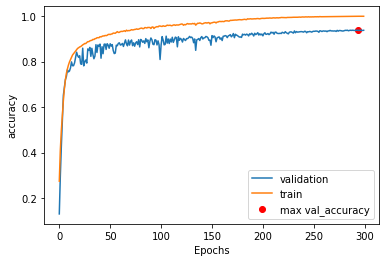

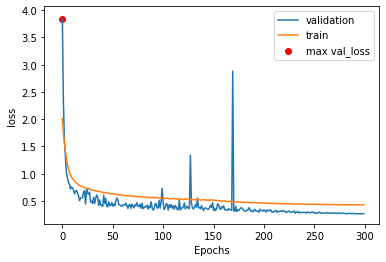

0.0621 in 280.5 min



In [27]:
ChromosomeOp.INITIAL_FILTERS = 10
ChromosomeOp.CELLS_PER_BLOCK = 2
ChromosomeOp.N_BLOCKS = 3
winner = generational.best_individual['winner']
fitness_cnn.precise_epochs = 75
fitness_cnn.verb = True
fitness_cnn.smooth = 0.1
fitness_cnn.learning_rate_base = 0.05
fitness_cnn.batch_size= 128
score = fitness_cnn.calc(winner, test=True, precise_mode=True, augmnt=True)

(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 10) (10000, 10) (10000, 10)


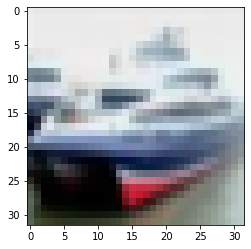

In [26]:
print(fitness_cnn.x_train.shape, fitness_cnn.x_test.shape, fitness_cnn.x_val.shape)
print(fitness_cnn.y_train.shape, fitness_cnn.y_test.shape, fitness_cnn.y_val.shape)


x = fitness_cnn.x_test[1]
import matplotlib.pyplot as plt
plt.imshow(x)

for xi in fitness_cnn.x_train:
    if np.sum(xi == x) == 32*32*3:
        print("Puta la wea")
        break


Training... Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 45)   1260        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 44)   2024        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 44)   176         conv2d_2[0][0]                   
________________________________________________________________________________

Epoch 1/300
312/312 [==============================] - 73s 235ms/step - loss: 4.2589 - accuracy: 0.0652 - val_loss: 20.0328 - val_accuracy: 0.0085
Epoch 2/300
312/312 [==============================] - 66s 210ms/step - loss: 3.8209 - accuracy: 0.1417 - val_loss: 6.7070 - val_accuracy: 0.0419
Epoch 3/300
312/312 [==============================] - 66s 211ms/step - loss: 3.5102 - accuracy: 0.2086 - val_loss: 4.6667 - val_accuracy: 0.1361
Epoch 4/300
312/312 [==============================] - 67s 215ms/step - loss: 3.2154 - accuracy: 0.2760 - val_loss: 3.8555 - val_accuracy: 0.2100
Epoch 5/300
312/312 [==============================] - 67s 213ms/step - loss: 2.9616 - accuracy: 0.3385 - val_loss: 3.0021 - val_accuracy: 0.3003
Epoch 6/300
312/312 [==============================] - 66s 213ms/step - loss: 2.7743 - accuracy: 0.3921 - val_loss: 2.9572 - val_accuracy: 0.3126
Epoch 7/300
312/312 [==============================] - 67s 213ms/step - loss: 2.6190 - accuracy: 0.4384 - val_loss: 2.5321 

Epoch 57/300
312/312 [==============================] - 67s 213ms/step - loss: 1.3982 - accuracy: 0.8464 - val_loss: 1.5075 - val_accuracy: 0.6271
Epoch 58/300
312/312 [==============================] - 67s 215ms/step - loss: 1.4086 - accuracy: 0.8390 - val_loss: 1.7051 - val_accuracy: 0.5887
Epoch 59/300
312/312 [==============================] - 68s 217ms/step - loss: 1.3997 - accuracy: 0.8460 - val_loss: 1.5964 - val_accuracy: 0.6031
Epoch 60/300
312/312 [==============================] - 68s 218ms/step - loss: 1.3890 - accuracy: 0.8467 - val_loss: 1.5746 - val_accuracy: 0.6136
Epoch 61/300
312/312 [==============================] - 68s 217ms/step - loss: 1.3887 - accuracy: 0.8482 - val_loss: 1.6044 - val_accuracy: 0.6034
Epoch 62/300
312/312 [==============================] - 68s 217ms/step - loss: 1.3834 - accuracy: 0.8500 - val_loss: 1.6624 - val_accuracy: 0.6029
Epoch 63/300
312/312 [==============================] - 68s 217ms/step - loss: 1.3771 - accuracy: 0.8526 - val_loss: 1

312/312 [==============================] - 67s 214ms/step - loss: 1.1792 - accuracy: 0.9337 - val_loss: 1.5319 - val_accuracy: 0.6392
Epoch 168/300
312/312 [==============================] - 67s 215ms/step - loss: 1.1653 - accuracy: 0.9369 - val_loss: 1.5393 - val_accuracy: 0.6422
Epoch 169/300
312/312 [==============================] - 67s 214ms/step - loss: 1.1587 - accuracy: 0.9392 - val_loss: 1.6449 - val_accuracy: 0.6159
Epoch 170/300
312/312 [==============================] - 67s 214ms/step - loss: 1.1473 - accuracy: 0.9428 - val_loss: 1.5605 - val_accuracy: 0.6420
Epoch 171/300
312/312 [==============================] - 67s 214ms/step - loss: 1.1473 - accuracy: 0.9434 - val_loss: 1.4748 - val_accuracy: 0.6546
Epoch 172/300
312/312 [==============================] - 67s 214ms/step - loss: 1.1420 - accuracy: 0.9451 - val_loss: 1.6097 - val_accuracy: 0.6262
Epoch 173/300
312/312 [==============================] - 67s 214ms/step - loss: 1.1411 - accuracy: 0.9452 - val_loss: 1.5578 -

312/312 [==============================] - 67s 214ms/step - loss: 0.9094 - accuracy: 0.9972 - val_loss: 1.2968 - val_accuracy: 0.7090
Epoch 277/300
312/312 [==============================] - 67s 214ms/step - loss: 0.9078 - accuracy: 0.9978 - val_loss: 1.3023 - val_accuracy: 0.6986
Epoch 278/300
312/312 [==============================] - 67s 214ms/step - loss: 0.9057 - accuracy: 0.9977 - val_loss: 1.2940 - val_accuracy: 0.7028
Epoch 279/300
312/312 [==============================] - 67s 214ms/step - loss: 0.9063 - accuracy: 0.9975 - val_loss: 1.2971 - val_accuracy: 0.7050
Epoch 280/300
312/312 [==============================] - 67s 214ms/step - loss: 0.9034 - accuracy: 0.9981 - val_loss: 1.3027 - val_accuracy: 0.7048
Epoch 281/300
312/312 [==============================] - 67s 214ms/step - loss: 0.9021 - accuracy: 0.9981 - val_loss: 1.2841 - val_accuracy: 0.7099
Epoch 282/300
312/312 [==============================] - 67s 214ms/step - loss: 0.9031 - accuracy: 0.9977 - val_loss: 1.2810 -

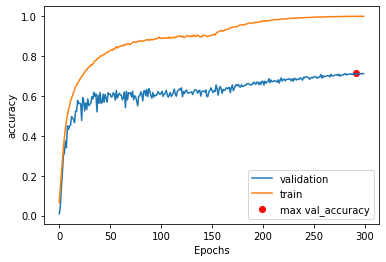

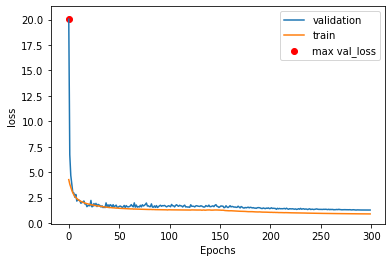

0.2782 in 341.2 min



In [43]:
ChromosomeOp.INITIAL_FILTERS = 45
#ChromosomeOp.CELLS_PER_BLOCK = 1
#ChromosomeOp.N_BLOCKS = 1
winner = generational.best_individual['winner']
fitness_cnn.precise_epochs = 300
fitness_cnn.verb = True
fitness_cnn.smooth = 0.1
fitness_cnn.learning_rate_base = 0.05
score = fitness_cnn.calc(winner, test=True, precise_mode=True, augmnt=True)

In [21]:
from keras.datasets import cifar100, cifar10

data = cifar100.load_data()
data2 = cifar10.load_data()



In [30]:
len(data), len(data2)
len(data[1]), len(data2[1])
type(data[0][0]), type(data2[0][0])
for i in range(2):
    for j in range(2):
        print(data[i][j].shape, data2[i][j].shape)

(50000, 32, 32, 3) (50000, 32, 32, 3)
(50000, 1) (50000, 1)
(10000, 32, 32, 3) (10000, 32, 32, 3)
(10000, 1) (10000, 1)


### Evolve MRDBI 1 cells per block and 1 blocks

In [17]:
experiments_folder = '../../exp_op_coding_VM3'

experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)
    
    try:
        generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
    except:
        # Load data
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps)

        fitness_cnn.save(fitness_file)

        del dm, data

        fitness = FitnessCNNParallel()
        fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                       fp=32, main_line=command)
        generational = TwoLevelGA(chromosome=c,
                                  fitness=fitness,
                                  generations=generations,
                                  population_first_level=population_first_level,
                                  population_second_level=population_second_level,
                                  training_hours=training_hours,
                                  save_progress=save_progress,
                                  maximize_fitness=maximize_fitness,
                                  statistical_validation=statistical_validation,
                                  folder=folder,
                                  start_level2=start_level2,
                                  frequency_second_level=frequency_second_level)
        generational.print("Experiment with fitness calculation using mean of thee best val accuracies. \
                           \nAlso using limited precision to dropout values")

        
    ti_all = time()
    winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))
    print("Previous elapsed time: %s" % "Generation (24) in 1380.97 minutes.")


EVOLVING IN DATASET MRDBI ...

Loading file ../../exp_op_coding_VM3/MRDBI/genetic/0_2019-12-05-17:19/GA_experiment

Start evolution process...


22) Ranking level 1... Models to train: 0 ...OK (in 0.00 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

22) Ranking level 2... Models to train: 4 ...

KeyboardInterrupt: 

In [19]:
#ChromosomeOp.INITIAL_FILTERS = 64
#ChromosomeOp.CELLS_PER_BLOCK = 1
#ChromosomeOp.N_BLOCKS = 1
winner = generational.best_individual['winner']
fitness_cnn.precise_epochs = 75
fitness_cnn.verb = True
fitness_cnn.smooth = 0.1
fitness_cnn.learning_rate_base = 0.02
score = generational.fitness_evaluator.calc(winner, test=True, precise_mode=True)

In [18]:
for k,v in generational.best_individual.items():
    print(k)
    print(v)
    print()
print(winner)

winner
||CNN|F:1.04|K:3|A:relu|D:0.25||woCAT||1||
||CNN|F:1.02|K:7|A:relu|D:0.45||woCAT||01||
||CNN|F:0.88|K:7|A:prelu|D:0.20||CAT||011||
||CNN|F:0.95|K:7|A:prelu|D:0.30||CAT||1001||
||CNN|F:1.14|K:7|A:relu|D:0.30||woCAT||00001||


best_fit
0.098194

||CNN|F:0.98|K:1|A:relu|D:0.20||woCAT||1||
||CNN|F:1.12|K:7|A:elu|D:0.15||CAT||11||
||CNN|F:0.77|K:5|A:prelu|D:0.40||CAT||111||
||CNN|F:0.85|K:5|A:elu|D:0.40||CAT||1111||
||CNN|F:0.85|K:5|A:elu|D:0.35||CAT||00101||
||CNN|F:1.05|K:7|A:elu|D:0.45||CAT||010001||



#### Evolution with 2 cells per block and 2 blocks

In [32]:
datasets = ['cifar10']
experiments_folder = '../../exp_op_coding'

experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)
    
    try:
        generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
    except:
        # Load data
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps)

        fitness_cnn.save(fitness_file)

        del dm, data

        fitness = FitnessCNNParallel()
        fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                       fp=32, main_line=command)
        generational = TwoLevelGA(chromosome=c,
                                  fitness=fitness,
                                  generations=generations,
                                  population_first_level=population_first_level,
                                  population_second_level=population_second_level,
                                  training_hours=training_hours,
                                  save_progress=save_progress,
                                  maximize_fitness=maximize_fitness,
                                  statistical_validation=statistical_validation,
                                  folder=folder,
                                  start_level2=start_level2,
                                  frequency_second_level=frequency_second_level)
        
    print(generational.generation)
    print(generational.num_generations)
    if generational.generation < generational.num_generations:
        winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))


EVOLVING IN DATASET cifar10 ...

Loading file ../../exp_op_coding/cifar10/genetic/0_2019-11-22-16:23/GA_experiment
30
30
Total elapsed time: 6644.763


In [33]:
print(generational.best_individual['winner'])

||Maxpool||woCAT||1||
||Identity||woCAT||01||
||CNN|F:0.71|K:5|A:relu|D:0.10||SUM||101||
||CNN|F:0.72|K:3|A:prelu|D:0.00||CAT||1101||



In [26]:
# Load data
num_clases = 100 if dataset == 'cifar100' else 10
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, num_clases=num_clases) #, max_examples=8000)
data = dm.load_data()
fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
               epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
               warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
               precise_epochs=precise_eps)

(40000, 32, 32, 3) train samples
(10000, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples


Training... Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 45)   1260        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 45)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 45)   2070        conv2d_1[0][0]                   
________________________________________________________________________________

Epoch 1/300
390/390 [==============================] - 89s 229ms/step - loss: 1.5453 - accuracy: 0.5085 - val_loss: 5.8909 - val_accuracy: 0.1555
Epoch 2/300
390/390 [==============================] - 83s 213ms/step - loss: 1.2059 - accuracy: 0.6701 - val_loss: 0.9957 - val_accuracy: 0.6698
Epoch 3/300
390/390 [==============================] - 84s 215ms/step - loss: 1.0397 - accuracy: 0.7480 - val_loss: 0.7548 - val_accuracy: 0.7522
Epoch 4/300
390/390 [==============================] - 86s 220ms/step - loss: 0.9434 - accuracy: 0.7938 - val_loss: 0.8421 - val_accuracy: 0.7272
Epoch 5/300
390/390 [==============================] - 87s 224ms/step - loss: 0.8817 - accuracy: 0.8196 - val_loss: 0.5999 - val_accuracy: 0.8155
Epoch 6/300
390/390 [==============================] - 88s 225ms/step - loss: 0.8340 - accuracy: 0.8420 - val_loss: 0.7730 - val_accuracy: 0.7490
Epoch 7/300
390/390 [==============================] - 88s 226ms/step - loss: 0.7981 - accuracy: 0.8577 - val_loss: 0.6949 -

Epoch 57/300
390/390 [==============================] - 84s 217ms/step - loss: 0.5149 - accuracy: 0.9749 - val_loss: 0.3631 - val_accuracy: 0.8970
Epoch 58/300
390/390 [==============================] - 85s 217ms/step - loss: 0.5140 - accuracy: 0.9732 - val_loss: 0.3978 - val_accuracy: 0.8912
Epoch 59/300
390/390 [==============================] - 85s 217ms/step - loss: 0.5084 - accuracy: 0.9760 - val_loss: 0.3729 - val_accuracy: 0.8918
Epoch 60/300
390/390 [==============================] - 85s 218ms/step - loss: 0.5137 - accuracy: 0.9748 - val_loss: 0.3613 - val_accuracy: 0.8963
Epoch 61/300
390/390 [==============================] - 85s 218ms/step - loss: 0.5099 - accuracy: 0.9763 - val_loss: 0.3334 - val_accuracy: 0.9092
Epoch 62/300
390/390 [==============================] - 85s 218ms/step - loss: 0.5121 - accuracy: 0.9751 - val_loss: 0.3700 - val_accuracy: 0.9023
Epoch 63/300
390/390 [==============================] - 85s 218ms/step - loss: 0.5063 - accuracy: 0.9777 - val_loss: 0

390/390 [==============================] - 86s 220ms/step - loss: 0.4440 - accuracy: 0.9962 - val_loss: 0.2837 - val_accuracy: 0.9290
Epoch 168/300
390/390 [==============================] - 86s 219ms/step - loss: 0.4462 - accuracy: 0.9955 - val_loss: 0.3137 - val_accuracy: 0.9220
Epoch 169/300
390/390 [==============================] - 86s 219ms/step - loss: 0.4457 - accuracy: 0.9955 - val_loss: 0.2924 - val_accuracy: 0.9278
Epoch 170/300
390/390 [==============================] - 86s 219ms/step - loss: 0.4442 - accuracy: 0.9965 - val_loss: 0.2980 - val_accuracy: 0.9247
Epoch 171/300
390/390 [==============================] - 86s 220ms/step - loss: 0.4441 - accuracy: 0.9959 - val_loss: 0.2873 - val_accuracy: 0.9309
Epoch 172/300
390/390 [==============================] - 86s 219ms/step - loss: 0.4461 - accuracy: 0.9956 - val_loss: 0.2902 - val_accuracy: 0.9303
Epoch 173/300
390/390 [==============================] - 86s 220ms/step - loss: 0.4414 - accuracy: 0.9969 - val_loss: 0.2805 -

390/390 [==============================] - 86s 220ms/step - loss: 0.4144 - accuracy: 1.0000 - val_loss: 0.2520 - val_accuracy: 0.9464
Epoch 278/300
390/390 [==============================] - 86s 220ms/step - loss: 0.4139 - accuracy: 1.0000 - val_loss: 0.2436 - val_accuracy: 0.9471
Epoch 279/300
390/390 [==============================] - 86s 220ms/step - loss: 0.4144 - accuracy: 0.9999 - val_loss: 0.2421 - val_accuracy: 0.9462
Epoch 280/300
390/390 [==============================] - 86s 220ms/step - loss: 0.4146 - accuracy: 1.0000 - val_loss: 0.2454 - val_accuracy: 0.9468
Epoch 281/300
390/390 [==============================] - 86s 220ms/step - loss: 0.4137 - accuracy: 1.0000 - val_loss: 0.2443 - val_accuracy: 0.9471
Epoch 282/300
390/390 [==============================] - 86s 220ms/step - loss: 0.4137 - accuracy: 1.0000 - val_loss: 0.2427 - val_accuracy: 0.9481
Epoch 283/300
390/390 [==============================] - 86s 220ms/step - loss: 0.4140 - accuracy: 1.0000 - val_loss: 0.2428 -

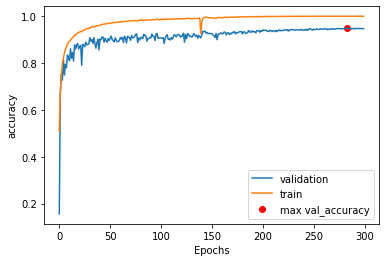

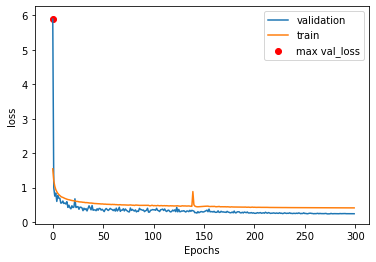

0.0513 in 430.9 min



In [27]:
ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 2
ChromosomeOp.N_BLOCKS = 2
winner = generational.best_individual['winner']
fitness_cnn.precise_epochs = 75
fitness_cnn.verb = True
fitness_cnn.smooth = 0.1
fitness_cnn.learning_rate_base = 0.05
fitness_cnn.batch_size= 128
score = fitness_cnn.calc(winner, test=True, precise_mode=True, augmnt=True)


Start evolution process...


9) Ranking level 1... Models to train: 0 ...OK (in 0.00 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

9) Ranking level 2... Models to train: 0 ...OK (in 0.00 minutes)
Saving... Elapsed saved time: 0.001
[[1 0 0 0]
 [0 1 0 0]
 [1 0 1 0]
 [1 1 0 1]]
[[1 0 0]
 [0 1 0]
 [1 0 1]]
[[1 0 0 0]
 [1 1 0 0]
 [0 1 1 0]
 [1 0 0 1]]
[[1 0 0 0]
 [0 1 0 0]
 [1 1 1 0]
 [1 1 0 1]]
[[1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 1 0 1]]
[[1 0 0]
 [0 1 0]
 [0 1 1]]
[[1 0 0]
 [1 1 0]
 [0 0 1]]
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 1 1 0 0]
 [0 0 0 1 0]
 [1 0 0 0 1]]
[[1 0]
 [0 1]]
[[1 0 0 0]
 [1 1 0 0]
 [1 0 1 0]
 [0 1 0 1]]
[[1 0 0]
 [1 1 0]
 [1 0 1]]
[[1 0 0 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 1 1 1]]
[[1 0 0 0]
 [1 1 0 0]
 [0 1 1 0]
 [0 0 0 1]]
[[1 0 0]
 [1 0 0]
 [0 1 1]]
[[1]]
[[1 0 0 0]
 [0 1 0 0]
 [1 1 1 0]
 [0 1 0 1]]
[[1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 1 0 1]]
[[1]]
[[1 0 0 0 0]
 [1 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 1 0]
 [0 1 0 0 1]]

Generation (9) in 0.00 

16) Ranking level 1... Models to train: 15 ...OK (in 46.82 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.002

16) Ranking level 2... Models to train: 3 ...OK (in 117.23 minutes)
Saving... Elapsed saved time: 0.002
[[1 0 0 0]
 [1 1 0 0]
 [1 0 1 0]
 [1 1 0 1]]
[[1 0 0 0]
 [1 0 0 0]
 [1 0 1 0]
 [1 1 0 1]]
[[1 0 0 0]
 [1 1 0 0]
 [0 0 1 0]
 [1 0 1 1]]
[[1 0 0 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 1 0 1]]
[[1 0 0 0]
 [1 0 0 0]
 [1 1 1 0]
 [0 1 0 1]]
[[1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 1 1 1]]
[[1 0 0 0]
 [1 0 0 0]
 [1 1 1 0]
 [1 1 1 1]]
[[1 0 0 0]
 [1 0 0 0]
 [1 1 1 0]
 [1 1 0 1]]
[[1 0 0 0]
 [1 1 0 0]
 [1 1 0 0]
 [0 1 1 1]]
[[1 0 0 0]
 [1 0 0 0]
 [0 1 1 0]
 [1 1 0 1]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [1 1 0 1]]
[[1 0 0 0]
 [0 1 0 0]
 [0 1 1 0]
 [1 0 0 1]]
[[1 0 0 0]
 [1 0 0 0]
 [1 0 1 0]
 [1 1 0 1]]
[[1 0 0 0 0]
 [1 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]
[[1 0 0 0]
 [0 1 0 0]
 [1 0 1 0]
 [0 0 0 1]]
[[1 0 0 0]
 [0 1 0 0]
 [1 1 1 0]
 [0 1 0 1]]
[[1 0 0 0]


23) Ranking level 1... Models to train: 14 ...OK (in 58.85 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.002

23) Ranking level 2... Models to train: 3 ...OK (in 27.82 minutes)
Saving... Elapsed saved time: 0.002
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 1 0 0]
 [1 0 0 1 0]
 [0 1 0 0 1]]
[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 1 1 0 0]
 [1 0 1 1 0]
 [1 1 0 0 1]]
[[1 0 0 0 0]
 [0 1 0 0 0]
 [1 1 0 0 0]
 [1 0 0 1 0]
 [0 0 1 0 1]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [1 1 0 1]]
[[1 0 0 0 0]
 [1 1 0 0 0]
 [1 0 0 0 0]
 [1 0 1 1 0]
 [0 0 1 0 1]]
[[1 0 0 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 0 0 1]]
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 1 0 0]
 [1 0 0 1 0]
 [1 1 0 0 1]]
[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 0 1 1 0]
 [1 1 0 0 1]]
[[1 0 0 0 0]
 [0 1 0 0 0]
 [1 0 1 0 0]
 [1 0 1 1 0]
 [1 0 1 0 1]]
[[1 0 0 0]
 [1 1 0 0]
 [1 0 1 0]
 [1 1 0 1]]
[[1 0 0 0]
 [1 1 0 0]
 [0 0 1 0]
 [1 0 0 1]]
[[1 0 0 0]
 [1 1 0 0]
 [1 1 1 0]
 [0 0 1 1]]
[[1 0 0 0]
 [0 1 0 0]
 [0 1 1 0]
 [1 1 0 1]]
[[1 0 0 0 0]
 [1 1 0 

30) Ranking level 1... Models to train: 15 ...OK (in 53.38 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.002

30) Ranking level 2... Models to train: 3 ...OK (in 84.37 minutes)
Saving... Elapsed saved time: 0.002

Generation (30) in 2778.04 minutes.
Best first level fitness: 0.07970
Best second level fitness: 0.05610
Best Gen -> 
||Maxpool||woCAT||1||
||Identity||woCAT||01||
||CNN|F:0.71|K:5|A:relu|D:0.100||SUM||101||
||CNN|F:0.72|K:3|A:prelu|D:0.009||CAT||1101||

With Fitness (val): 0.0561 and (test): 0.0651


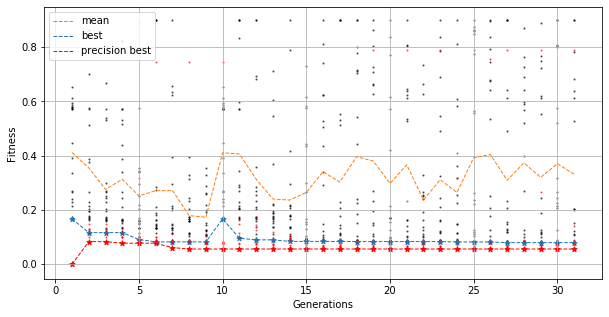

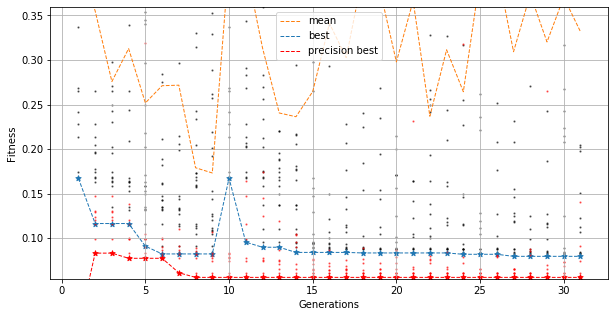

Total elapsed time: 170192.919


In [7]:
generational.training_hours = 48
ti_all = time()
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))

In [ ]:
ranking1 = generational.evaluate_population(level=1)
ranking2 = generational.evaluate_population(level=2)

In [ ]:
ranking1

In [ ]:
ranking2

Training... Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 45)   1260        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 45)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 45)   2070        conv2d_1[0][0]                   
________________________________________________________________________________

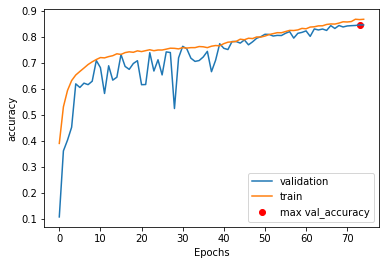

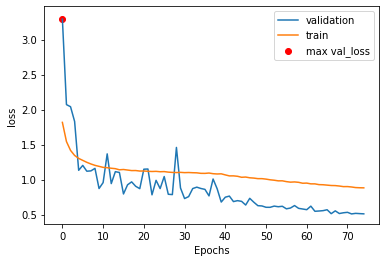

0.1590 in 16.5 min



In [13]:
fitness_cnn.precise_epochs = 75
fitness_cnn.verb = True
fitness_cnn.smooth = 0.1
fitness_cnn.learning_rate_base = 0.05
score = fitness_cnn.calc(winner, test=True, precise_mode=True, augmnt=True)

Training... Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 45)   1260        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 45)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 45)   2070        conv2d_1[0][0]                   
________________________________________________________________________________

Epoch 1/75
312/312 [==============================] - 74s 237ms/step - loss: 1.6045 - accuracy: 0.5004 - val_loss: 12.3831 - val_accuracy: 0.0983
Epoch 2/75
312/312 [==============================] - 71s 227ms/step - loss: 1.2577 - accuracy: 0.6736 - val_loss: 0.9342 - val_accuracy: 0.6986
Epoch 3/75
312/312 [==============================] - 71s 228ms/step - loss: 1.1200 - accuracy: 0.7395 - val_loss: 0.9488 - val_accuracy: 0.6918
Epoch 4/75
312/312 [==============================] - 72s 230ms/step - loss: 1.0363 - accuracy: 0.7806 - val_loss: 0.9133 - val_accuracy: 0.7116
Epoch 5/75
312/312 [==============================] - 73s 234ms/step - loss: 0.9853 - accuracy: 0.8039 - val_loss: 1.0119 - val_accuracy: 0.6635
Epoch 6/75
312/312 [==============================] - 72s 231ms/step - loss: 0.9429 - accuracy: 0.8243 - val_loss: 0.8493 - val_accuracy: 0.7385
Epoch 7/75
312/312 [==============================] - 73s 233ms/step - loss: 0.9124 - accuracy: 0.8378 - val_loss: 0.7850 - val_a

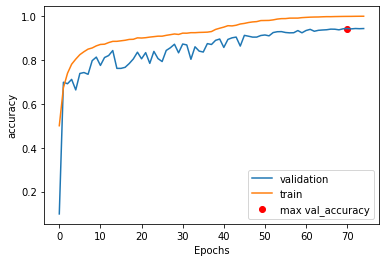

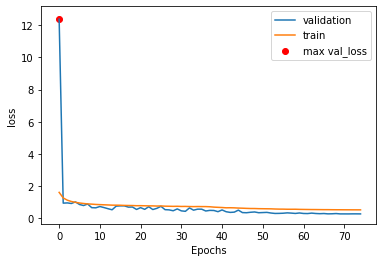

0.0634 in 92.1 min



In [19]:
w = generational.best_individual['winner']
ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 2
ChromosomeOp.N_BLOCKS = 2

fitness_cnn.precise_epochs = 75
score = fitness_cnn.calc(winner, test=True, precise_mode=True, augmnt=True)

Training... Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 45)   1260        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 40)   1840        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 40)   160         conv2d_2[0][0]                   
________________________________________________________________________________

Epoch 1/108
312/312 [==============================] - 149s 479ms/step - loss: 1.6369 - accuracy: 0.4814 - val_loss: 1.8080 - val_accuracy: 0.4145
Acc -> Val acc: 0.5855,Test (best_acc) acc: 0.5784


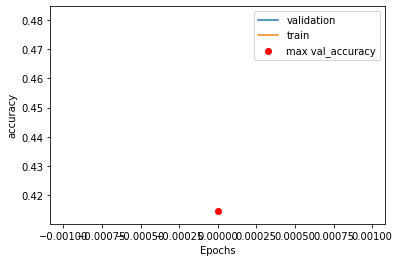

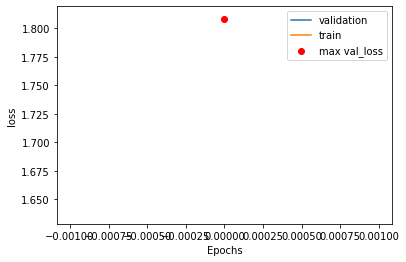

0.5784 in 3.6 min



In [12]:
w = generational.best_individual['winner']
ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 2
ChromosomeOp.N_BLOCKS = 2

fitness_cnn.precise_epochs = 108
score = fitness_cnn.calc(winner, test=True, precise_mode=True, augmnt=True)

#### Evolution with 1 cell per block and 1 block

In [8]:
experiments_folder = '../../exp_op_coding2'
experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)
    
    try:
        generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
        break
    except:
        # Load data
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps)

        fitness_cnn.save(fitness_file)

        del dm, data

        fitness = FitnessCNNParallel()
        fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                       fp=32, main_line=command)
        generational = TwoLevelGA(chromosome=c,
                                  fitness=fitness,
                                  generations=generations,
                                  population_first_level=population_first_level,
                                  population_second_level=population_second_level,
                                  training_hours=training_hours,
                                  save_progress=save_progress,
                                  maximize_fitness=maximize_fitness,
                                  statistical_validation=statistical_validation,
                                  folder=folder,
                                  start_level2=start_level2,
                                  frequency_second_level=frequency_second_level)
        
    ti_all = time()
    winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))


EVOLVING IN DATASET cifar10 ...

Loading file ../../exp_op_coding2/cifar10/genetic/0_2019-11-26-01:38/GA_experiment


In [10]:
print(generational.ti/3600)

437428.6479702789


In [6]:
# Load data
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
data = dm.load_data()
fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps)

(40000, 32, 32, 3) train samples
(10000, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples


In [19]:
fitness_cnn.verb = True
fitness_cnn.precise_epochs = 75

w = generational.best_individual['winner']
w_copy = w.self_copy()
for block in w_copy.blocks:
    for op in block.ops:
        if op.type() == 'CNN':
            op.k_size = 3

print(w)
print(w_copy)

||CNN|F:0.86|K:7|A:prelu|D:0.130||woCAT||1||
||CNN|F:1.02|K:7|A:prelu|D:0.161||SUM||11||
||CNN|F:0.97|K:7|A:elu|D:0.288||SUM||111||
||CNN|F:1.02|K:5|A:relu|D:0.091||CAT||1001||

||CNN|F:0.86|K:3|A:prelu|D:0.130||woCAT||1||
||CNN|F:1.02|K:3|A:prelu|D:0.161||SUM||11||
||CNN|F:0.97|K:3|A:elu|D:0.288||SUM||111||
||CNN|F:1.02|K:3|A:relu|D:0.091||CAT||1001||



Training... Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 109)  125677      conv2d_1[0][0]                   
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 32, 32, 109)  111616      conv2d_2[0][0]                   
________________________________________________________________________________

Epoch 9/75
312/312 [==============================] - 50s 160ms/step - loss: 1.0660 - accuracy: 0.7730 - val_loss: 1.1210 - val_accuracy: 0.6532
Epoch 10/75
312/312 [==============================] - 50s 161ms/step - loss: 1.0489 - accuracy: 0.7801 - val_loss: 3.0457 - val_accuracy: 0.3665
Epoch 11/75
312/312 [==============================] - 51s 164ms/step - loss: 1.0375 - accuracy: 0.7854 - val_loss: 1.1700 - val_accuracy: 0.6395
Epoch 12/75
312/312 [==============================] - 51s 165ms/step - loss: 1.0228 - accuracy: 0.7953 - val_loss: 0.8735 - val_accuracy: 0.7121
Epoch 13/75
312/312 [==============================] - 51s 164ms/step - loss: 1.0241 - accuracy: 0.7946 - val_loss: 0.9043 - val_accuracy: 0.6974
Epoch 14/75
312/312 [==============================] - 51s 165ms/step - loss: 1.0076 - accuracy: 0.8036 - val_loss: 0.9061 - val_accuracy: 0.7058
Epoch 15/75
312/312 [==============================] - 52s 166ms/step - loss: 0.9981 - accuracy: 0.8087 - val_loss: 0.8441 - 

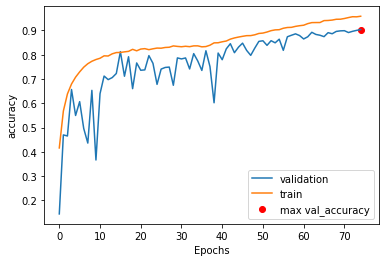

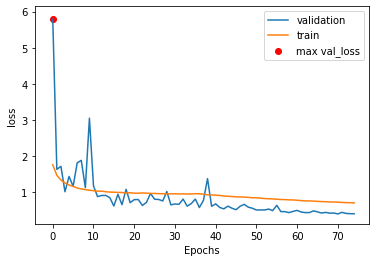

0.0961 in 67.2 min



In [21]:
  
# ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 1
ChromosomeOp.N_BLOCKS = 1

score = fitness_cnn.calc(w_copy, test=True, precise_mode=True, augmnt=True)

In [22]:
print(generational.best_individual)

{'winner': ||CNN|F:0.86|K:7|A:prelu|D:0.130||woCAT||1||
||CNN|F:1.02|K:7|A:prelu|D:0.161||SUM||11||
||CNN|F:0.97|K:7|A:elu|D:0.288||SUM||111||
||CNN|F:1.02|K:5|A:relu|D:0.091||CAT||1001||
, 'best_fit': 0.0845, 'test': 0.0909}


Training... Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 45)   1260        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 38)   15428       conv2d_1[0][0]                   
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 32, 32, 38)   38912       conv2d_2[0][0]                   
________________________________________________________________________________

Epoch 1/75
312/312 [==============================] - 34s 109ms/step - loss: 1.7341 - accuracy: 0.4286 - val_loss: 3.5466 - val_accuracy: 0.1403
Epoch 2/75
312/312 [==============================] - 29s 94ms/step - loss: 1.3752 - accuracy: 0.6119 - val_loss: 1.2518 - val_accuracy: 0.5921
Epoch 3/75
312/312 [==============================] - 29s 94ms/step - loss: 1.2431 - accuracy: 0.6798 - val_loss: 2.0291 - val_accuracy: 0.4146
Epoch 4/75
312/312 [==============================] - 29s 93ms/step - loss: 1.1704 - accuracy: 0.7170 - val_loss: 1.3901 - val_accuracy: 0.5648
Epoch 5/75
312/312 [==============================] - 29s 94ms/step - loss: 1.1141 - accuracy: 0.7443 - val_loss: 1.0854 - val_accuracy: 0.6356
Epoch 6/75
312/312 [==============================] - 30s 95ms/step - loss: 1.0750 - accuracy: 0.7645 - val_loss: 0.8852 - val_accuracy: 0.7042
Epoch 7/75
312/312 [==============================] - 30s 95ms/step - loss: 1.0470 - accuracy: 0.7776 - val_loss: 0.8749 - val_accuracy

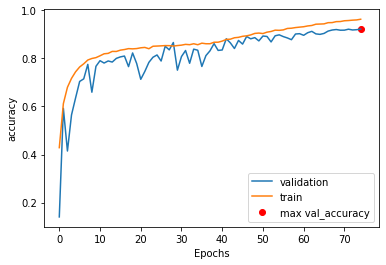

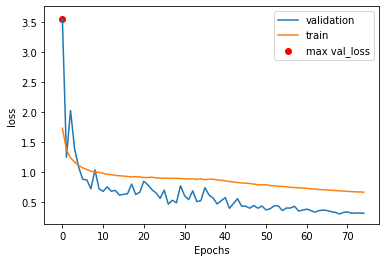

0.0806 in 38.8 min



In [24]:
ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 1
ChromosomeOp.N_BLOCKS = 2

score = fitness_cnn.calc(w_copy, test=True, precise_mode=True, augmnt=True)

Training... Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 45)   1260        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 38)   15428       conv2d_1[0][0]                   
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 32, 32, 38)   38912       conv2d_2[0][0]                   
________________________________________________________________________________

Epoch 1/75
312/312 [==============================] - 43s 136ms/step - loss: 1.7079 - accuracy: 0.4403 - val_loss: 3.5205 - val_accuracy: 0.1774
Epoch 2/75
312/312 [==============================] - 34s 110ms/step - loss: 1.3198 - accuracy: 0.6378 - val_loss: 1.1390 - val_accuracy: 0.6163
Epoch 3/75
312/312 [==============================] - 35s 113ms/step - loss: 1.1617 - accuracy: 0.7182 - val_loss: 1.5416 - val_accuracy: 0.4822
Epoch 4/75
312/312 [==============================] - 36s 116ms/step - loss: 1.0831 - accuracy: 0.7589 - val_loss: 0.7967 - val_accuracy: 0.7477
Epoch 5/75
312/312 [==============================] - 36s 116ms/step - loss: 1.0406 - accuracy: 0.7769 - val_loss: 1.0274 - val_accuracy: 0.6774
Epoch 6/75
312/312 [==============================] - 36s 115ms/step - loss: 1.0001 - accuracy: 0.7943 - val_loss: 0.8876 - val_accuracy: 0.7491
Epoch 7/75
312/312 [==============================] - 36s 115ms/step - loss: 0.9778 - accuracy: 0.8053 - val_loss: 0.8258 - val_ac

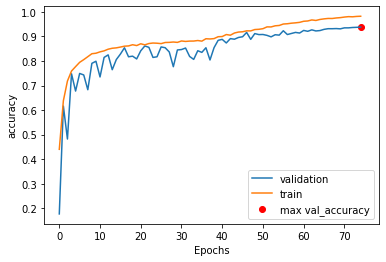

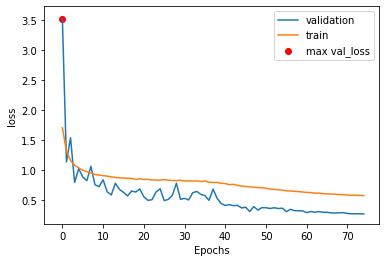

0.0661 in 46.4 min



In [25]:
ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 1
ChromosomeOp.N_BLOCKS = 3

score = fitness_cnn.calc(w_copy, test=True, precise_mode=True, augmnt=True)

Training... Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 45)   1260        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 38)   15428       conv2d_1[0][0]                   
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 32, 32, 38)   38912       conv2d_2[0][0]                   
________________________________________________________________________________

Epoch 1/75
312/312 [==============================] - 49s 158ms/step - loss: 1.7612 - accuracy: 0.4191 - val_loss: 4.9102 - val_accuracy: 0.1500
Epoch 2/75
312/312 [==============================] - 36s 117ms/step - loss: 1.3715 - accuracy: 0.6117 - val_loss: 1.1454 - val_accuracy: 0.6122
Epoch 3/75
312/312 [==============================] - 39s 124ms/step - loss: 1.1860 - accuracy: 0.7018 - val_loss: 0.8383 - val_accuracy: 0.7387
Epoch 4/75
312/312 [==============================] - 38s 123ms/step - loss: 1.0929 - accuracy: 0.7441 - val_loss: 0.9731 - val_accuracy: 0.7123
Epoch 5/75
312/312 [==============================] - 39s 124ms/step - loss: 1.0378 - accuracy: 0.7681 - val_loss: 0.9633 - val_accuracy: 0.6779
Epoch 6/75
312/312 [==============================] - 39s 124ms/step - loss: 1.0011 - accuracy: 0.7875 - val_loss: 0.7799 - val_accuracy: 0.7555
Epoch 7/75
312/312 [==============================] - 39s 125ms/step - loss: 0.9646 - accuracy: 0.8031 - val_loss: 0.9629 - val_ac

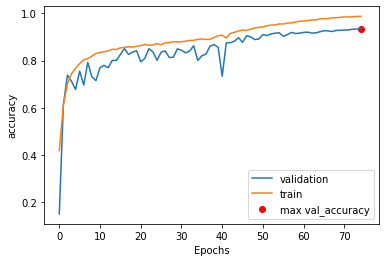

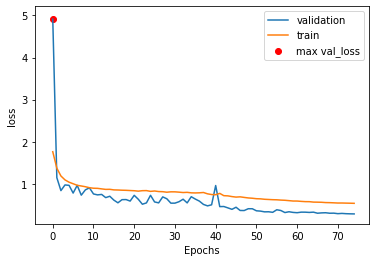

0.0698 in 49.7 min



In [26]:
ChromosomeOp.INITIAL_FILTERS = 45
ChromosomeOp.CELLS_PER_BLOCK = 1
ChromosomeOp.N_BLOCKS = 4

score = fitness_cnn.calc(w_copy, test=True, precise_mode=True, augmnt=True)

In [27]:
ChromosomeOp.INITIAL_FILTERS = 32
ChromosomeOp.CELLS_PER_BLOCK = 1
ChromosomeOp.N_BLOCKS = 3

score = fitness_cnn.calc(w_copy, test=True, precise_mode=True, augmnt=True)

Training... Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 27)   7803        conv2d_1[0][0]                   
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 32, 32, 27)   27648       conv2d_2[0][0]                   
________________________________________________________________________________

Epoch 1/75
312/312 [==============================] - 33s 105ms/step - loss: 1.7492 - accuracy: 0.4218 - val_loss: 3.8183 - val_accuracy: 0.1284
Epoch 2/75
312/312 [==============================] - 24s 76ms/step - loss: 1.3807 - accuracy: 0.6077 - val_loss: 1.1699 - val_accuracy: 0.6098
Epoch 3/75
312/312 [==============================] - 24s 76ms/step - loss: 1.2005 - accuracy: 0.7020 - val_loss: 0.8960 - val_accuracy: 0.6976
Epoch 4/75
312/312 [==============================] - 25s 79ms/step - loss: 1.1134 - accuracy: 0.7408 - val_loss: 0.8881 - val_accuracy: 0.7006
Epoch 5/75
312/312 [==============================] - 25s 81ms/step - loss: 1.0582 - accuracy: 0.7681 - val_loss: 0.8157 - val_accuracy: 0.7346
Epoch 6/75
312/312 [==============================] - 25s 79ms/step - loss: 1.0269 - accuracy: 0.7826 - val_loss: 1.3748 - val_accuracy: 0.5589
Epoch 7/75
312/312 [==============================] - 25s 80ms/step - loss: 0.9950 - accuracy: 0.7968 - val_loss: 0.8642 - val_accuracy

KeyboardInterrupt: 

#### Evolution with 1 cells per block and 3 blocks, but 45 filters
##### (and possible kernel sizes: 1, 3 and 5)


EVOLVING IN DATASET cifar10 ...

(40000, 32, 32, 3) train samples
(10000, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples
Number of individuals eliminated by age: 0
Genetic algorithm params
Number of generations: 30
Population size: 20
Folder to save: ../../exp_op_coding3/cifar10/genetic/0_2019-11-28-18:44/GA_experiment
num parents: 5
offspring size: 15

Population size level one: 20
Population size level two: 8
Number of parents level one: 5
Number of parents level two: 4
Offspring size level one: 15
Offspring size level two: 4
Creating Initial population

Start evolution process...


0) Ranking level 1... Models to train: 20 ...OK (in 35.32 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

1) Ranking level 1... Models to train: 12 ...OK (in 27.33 minutes)
Statistical validation in 0.00 minutes
Saving... Elapsed saved time: 0.001

1) Ranking level 2... Models to train: 8 ...OK (in 92.87 minutes)
Saving... Elapsed saved time: 0.001

2) 

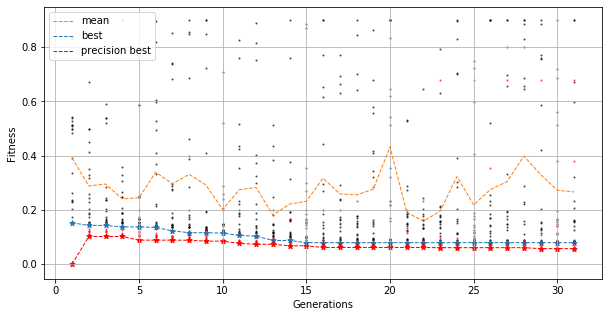

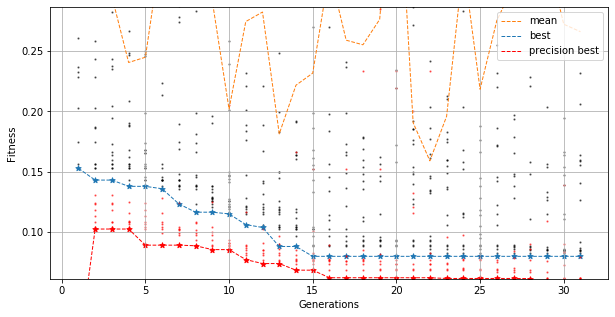

Total elapsed time: 231597.607


In [6]:
experiments_folder = '../../exp_op_coding3'
experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example')   
    os.makedirs(folder, exist_ok=True)
    
    try:
        generational = TwoLevelGA.load_genetic_algorithm(folder=folder)
        break
    except:
        # Load data
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder) #, max_examples=8000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                       epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                       warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps)
        fitness_cnn.save(fitness_file)

        del dm, data

        fitness = FitnessCNNParallel()
        fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                       fp=32, main_line=command)
        generational = TwoLevelGA(chromosome=c,
                                  fitness=fitness,
                                  generations=generations,
                                  population_first_level=population_first_level,
                                  population_second_level=population_second_level,
                                  training_hours=training_hours,
                                  save_progress=save_progress,
                                  maximize_fitness=maximize_fitness,
                                  statistical_validation=statistical_validation,
                                  folder=folder,
                                  start_level2=start_level2,
                                  frequency_second_level=frequency_second_level)
        
    ti_all = time()
    winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))


Training... Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 45)   1260        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 40)   1840        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 40)   160         conv2d_2[0][0]                   
________________________________________________________________________________

Epoch 1/200
312/312 [==============================] - 57s 183ms/step - loss: 1.6697 - accuracy: 0.4620 - val_loss: 3.8993 - val_accuracy: 0.1137
Epoch 2/200
312/312 [==============================] - 49s 157ms/step - loss: 1.3060 - accuracy: 0.6448 - val_loss: 0.9957 - val_accuracy: 0.6509
Epoch 3/200
312/312 [==============================] - 49s 158ms/step - loss: 1.1416 - accuracy: 0.7252 - val_loss: 1.0196 - val_accuracy: 0.6615
Epoch 4/200
312/312 [==============================] - 50s 160ms/step - loss: 1.0526 - accuracy: 0.7667 - val_loss: 0.9299 - val_accuracy: 0.6902
Epoch 5/200
312/312 [==============================] - 51s 162ms/step - loss: 0.9919 - accuracy: 0.7961 - val_loss: 0.9149 - val_accuracy: 0.7080
Epoch 6/200
312/312 [==============================] - 51s 163ms/step - loss: 0.9512 - accuracy: 0.8116 - val_loss: 0.7644 - val_accuracy: 0.7579
Epoch 7/200
312/312 [==============================] - 51s 164ms/step - loss: 0.9111 - accuracy: 0.8303 - val_loss: 0.6757 -

Epoch 57/200
312/312 [==============================] - 50s 159ms/step - loss: 0.6101 - accuracy: 0.9656 - val_loss: 0.3793 - val_accuracy: 0.9008
Epoch 58/200
312/312 [==============================] - 50s 159ms/step - loss: 0.6088 - accuracy: 0.9653 - val_loss: 0.4290 - val_accuracy: 0.8823
Epoch 59/200
312/312 [==============================] - 50s 159ms/step - loss: 0.6012 - accuracy: 0.9699 - val_loss: 0.3886 - val_accuracy: 0.8973
Epoch 60/200
312/312 [==============================] - 50s 159ms/step - loss: 0.6065 - accuracy: 0.9663 - val_loss: 0.3431 - val_accuracy: 0.9051
Epoch 61/200
312/312 [==============================] - 50s 159ms/step - loss: 0.6060 - accuracy: 0.9665 - val_loss: 0.3641 - val_accuracy: 0.9031
Epoch 62/200
312/312 [==============================] - 50s 159ms/step - loss: 0.6006 - accuracy: 0.9690 - val_loss: 0.4026 - val_accuracy: 0.8948
Epoch 63/200
312/312 [==============================] - 50s 159ms/step - loss: 0.5987 - accuracy: 0.9707 - val_loss: 0

312/312 [==============================] - 50s 159ms/step - loss: 0.5121 - accuracy: 0.9989 - val_loss: 0.2903 - val_accuracy: 0.9343
Epoch 168/200
312/312 [==============================] - 50s 159ms/step - loss: 0.5138 - accuracy: 0.9985 - val_loss: 0.2840 - val_accuracy: 0.9363
Epoch 169/200
312/312 [==============================] - 50s 159ms/step - loss: 0.5118 - accuracy: 0.9992 - val_loss: 0.2749 - val_accuracy: 0.9398
Epoch 170/200
312/312 [==============================] - 50s 159ms/step - loss: 0.5122 - accuracy: 0.9989 - val_loss: 0.3039 - val_accuracy: 0.9351
Epoch 171/200
312/312 [==============================] - 50s 159ms/step - loss: 0.5122 - accuracy: 0.9990 - val_loss: 0.2813 - val_accuracy: 0.9381
Epoch 172/200
312/312 [==============================] - 50s 159ms/step - loss: 0.5113 - accuracy: 0.9990 - val_loss: 0.2939 - val_accuracy: 0.9388
Epoch 173/200
312/312 [==============================] - 50s 159ms/step - loss: 0.5111 - accuracy: 0.9991 - val_loss: 0.2888 -

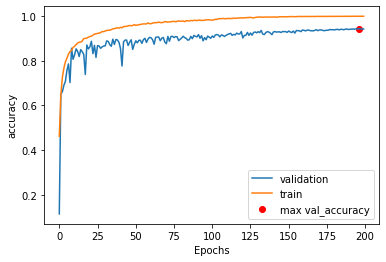

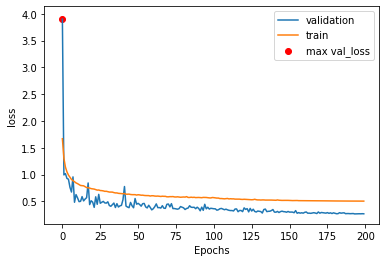

0.0632 in 167.7 min



In [7]:
ChromosomeOp.CELLS_PER_BLOCK = 1
ChromosomeOp.N_BLOCKS = 3

fitness_cnn.precise_epochs = 200
fitness_cnn.verb = True
score = fitness_cnn.calc(winner, test=True, precise_mode=True, augmnt=True)

In [15]:
generational.paint
generational.filename


'../../exp_cifar10_time_catv4/cifar10/genetic/0_2019-12-28-13:27/GA_experiment'